# Exploratory Data Analysis

In this notebook, we are going to explore the energy consumption data we loaded into the **data** directory. With the ETL notebook, we only kept 3 columns :
- **datetime** : date and time of record
- **prediction_unit_id** : a unique identifier for the ``county``, ``is_business``, and ``product_type`` combination (we removed these columns in the ETL script). Note that new prediction units can appear or dissappear with time, and so in the test set.
- **consumption** : the consumption amount for the relevant segment (prediction unit) for the corresponding hour.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Read the data

In [12]:
df = pd.read_csv("../data/raw/train.csv", parse_dates=["datetime"])
print(f"data shape : {df.shape}")
df.head()

data shape : (2018352, 9)


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01,0,0,0
1,0,0,1,96.590,1,2021-09-01,0,1,0
2,0,0,2,0.000,0,2021-09-01,0,2,1
3,0,0,2,17.314,1,2021-09-01,0,3,1
4,0,0,3,2.904,0,2021-09-01,0,4,2


In [13]:
# keeping only consumption data
df = df[df["is_consumption"] == 1].drop(columns=["is_consumption"])
df.head()

,county,is_business,product_type,target,datetime,data_block_id,row_id,prediction_unit_id
1,0,0,1,96.590,2021-09-01,0,1,0
3,0,0,2,17.314,2021-09-01,0,3,1
5,0,0,3,656.859,2021-09-01,0,5,2
7,0,1,0,59.000,2021-09-01,0,7,3
9,0,1,1,501.760,2021-09-01,0,9,4


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1009176 entries, 1 to 2018351
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   county              1009176 non-null  int64         
 1   is_business         1009176 non-null  int64         
 2   product_type        1009176 non-null  int64         
 3   target              1008912 non-null  float64       
 4   datetime            1009176 non-null  datetime64[ns]
 5   data_block_id       1009176 non-null  int64         
 6   row_id              1009176 non-null  int64         
 7   prediction_unit_id  1009176 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 69.3 MB


In [15]:
print("unique segments : \n{}".format(df["prediction_unit_id"].unique()))
print()
print("number of segments : {}".format(df["prediction_unit_id"].unique().size))

unique segments : 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68]

number of segments : 69


In [28]:
print(df["datetime"].max() - df["datetime"].min())

637 days 23:00:00


In [30]:
print("start date     : {}".format(df["datetime"].min()))
print("end date       : {}".format(df["datetime"].max()))
print("total duration : {}".format(df["datetime"].max() - df["datetime"].min()))

start date     : 2021-09-01 00:00:00
end date       : 2023-05-31 23:00:00
total duration : 637 days 23:00:00


In [31]:
# Let's look at the unique date ranges
unique_date_ranges = pd.concat(
    [
        df.groupby(by="prediction_unit_id")["datetime"].min().rename("start date"),
        df.groupby(by="prediction_unit_id")["datetime"].max().rename("end date"),
    ],
    axis=1,
).drop_duplicates()  # drop rows with same start and end dates
unique_date_ranges.sort_values(by="start date")

,start date,end date
prediction_unit_id,,
0,2021-09-01,2023-05-31 23:00:00
26,2021-09-01,2023-03-29 23:00:00
41,2021-09-01,2023-05-15 23:00:00
44,2021-09-01,2023-05-27 23:00:00
47,2021-09-01,2023-05-24 23:00:00
61,2021-10-01,2023-05-31 23:00:00
64,2021-12-01,2023-05-31 23:00:00
65,2022-01-01,2023-05-31 23:00:00
67,2022-02-01,2023-05-31 23:00:00


In [32]:
# sorted by end date
unique_date_ranges.sort_values(by="end date")

,start date,end date
prediction_unit_id,,
26,2021-09-01,2023-03-29 23:00:00
41,2021-09-01,2023-05-15 23:00:00
47,2021-09-01,2023-05-24 23:00:00
44,2021-09-01,2023-05-27 23:00:00
0,2021-09-01,2023-05-31 23:00:00
61,2021-10-01,2023-05-31 23:00:00
64,2021-12-01,2023-05-31 23:00:00
65,2022-01-01,2023-05-31 23:00:00
67,2022-02-01,2023-05-31 23:00:00


# Missing values

In [33]:
df.isna().sum()

county                  0
is_business             0
product_type            0
target                264
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64

At first glance, there are very few missing values in the dataset.

# Find missing dates

In [34]:
series = []
for prediction_unit_id in df["prediction_unit_id"].unique():
    s = df[df["prediction_unit_id"] == prediction_unit_id].set_index("datetime")
    s.index = pd.to_datetime(s.index)
    date_range = pd.date_range(start=s.index.min(), end=s.index.max(), freq="h")
    missing_dates = date_range[~date_range.isin(s.index)]
    s = s.reindex(date_range)
    s.index.name = "datetime"
    s["prediction_unit_id"] = prediction_unit_id
    series.append(s)

In [35]:
df_ = df.copy()
df = pd.concat(series).reset_index()
df.head()

,datetime,county,is_business,product_type,target,data_block_id,row_id,prediction_unit_id
0,2021-09-01 00:00:00,0.0,0.0,1.0,96.590,0.0,1.0,0
1,2021-09-01 01:00:00,0.0,0.0,1.0,77.691,0.0,123.0,0
2,2021-09-01 02:00:00,0.0,0.0,1.0,91.594,0.0,245.0,0
3,2021-09-01 03:00:00,0.0,0.0,1.0,87.955,0.0,367.0,0
4,2021-09-01 04:00:00,0.0,0.0,1.0,88.184,0.0,489.0,0


In [36]:
df.isna().sum()

datetime                  0
county                21096
is_business           21096
product_type          21096
target                21360
data_block_id         21096
row_id                21096
prediction_unit_id        0
dtype: int64

In [37]:
df.isna().mean()

datetime              0.000000
county                0.020476
is_business           0.020476
product_type          0.020476
target                0.020732
data_block_id         0.020476
row_id                0.020476
prediction_unit_id    0.000000
dtype: float64

We can see there are much more missing values when adding the missing dates and times in the dataset.

In [ ]:
# missing values per segment
nans_per_unit = (
    df[df["target"].isna()]
    .groupby("prediction_unit_id")["datetime"]
    .count()
    .sort_values(ascending=False)
    .rename("NaN counts")
)
nans_per_unit

prediction_unit_id
41    8858
26    3819
68    3432
47    3147
44    1108
      ... 
62       4
64       3
65       3
66       3
67       3
Name: NaN counts, Length: 69, dtype: int64

In [41]:
nans_per_unit[nans_per_unit > 4]

prediction_unit_id
41    8858
26    3819
68    3432
47    3147
44    1108
21     748
Name: NaN counts, dtype: int64

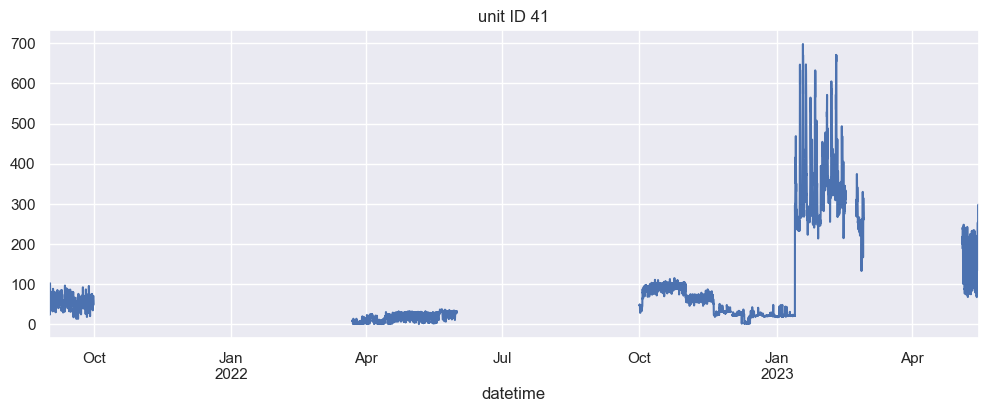

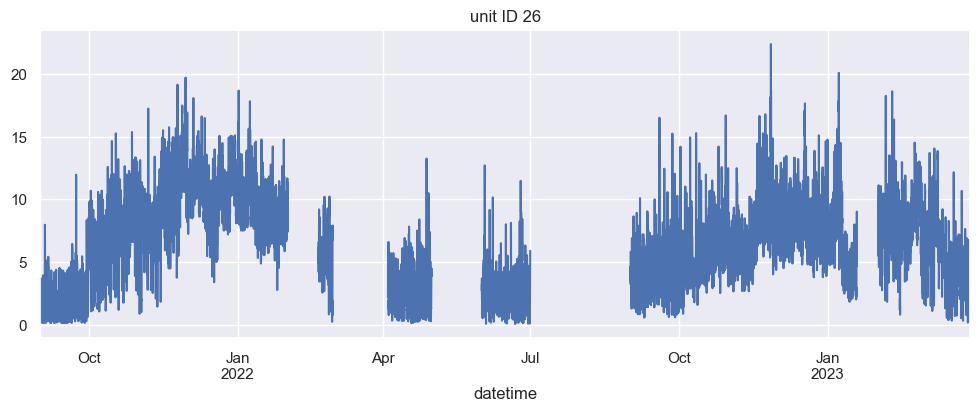

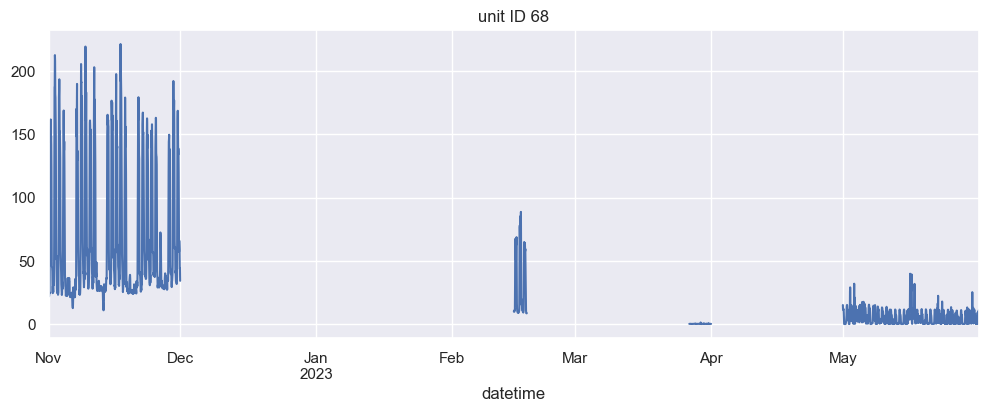

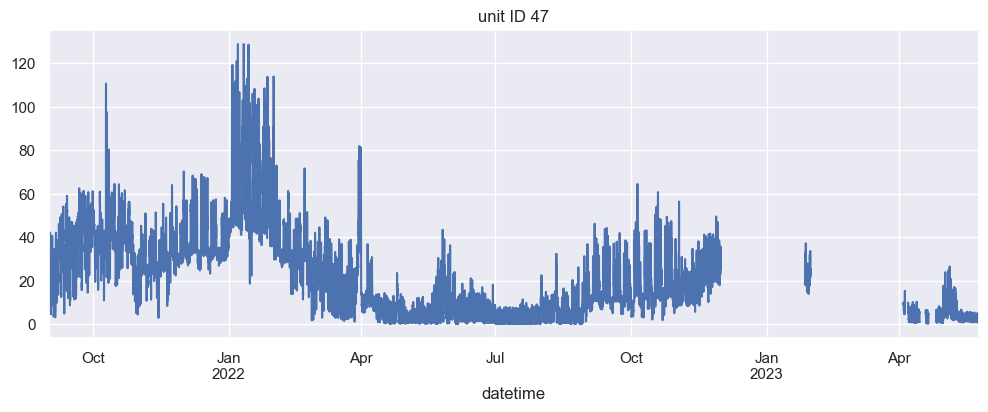

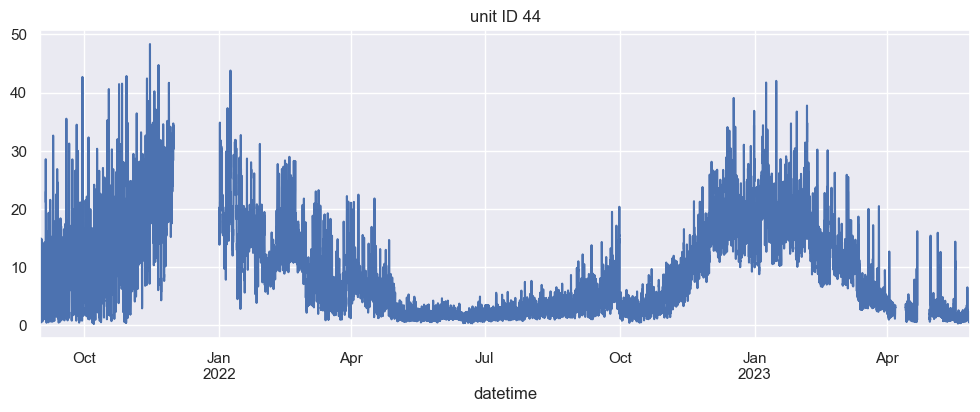

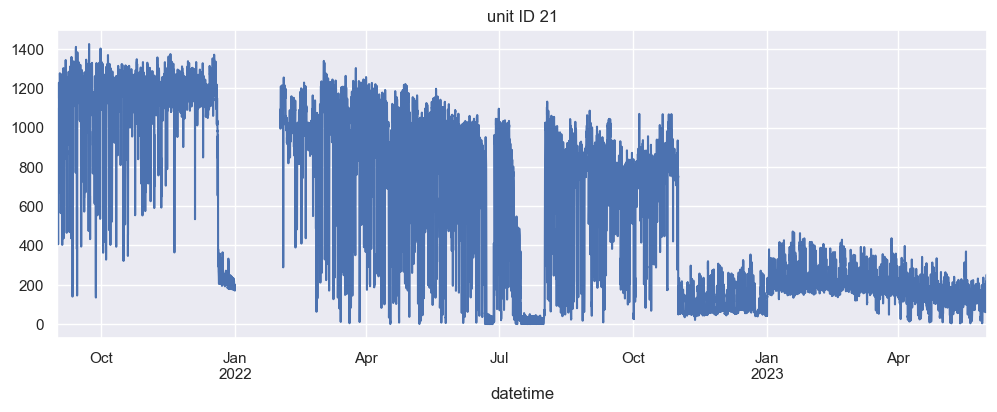

In [ ]:
# Plot data for units that have more than 4 missing values
for prediction_unit_id in nans_per_unit[nans_per_unit > 4].index:
    s = df[df["prediction_unit_id"] == prediction_unit_id].set_index("datetime")
    plt.figure(figsize=(12, 4))
    plt.title(f"unit ID {prediction_unit_id}")
    s["target"].plot()

# County and weather station locations

In [ ]:
# # cell copied from : https://www.kaggle.com/code/tsunotsuno/enefit-eda-baseline

# # Create a map object, centered around the average coordinates of Estonia
# folium_map = folium.Map(location=[58.595272, 25.013607], zoom_start=7)

# # Plot county point plot (red)
# for county, coords in counties_locations.items():
#     folium.CircleMarker(
#         location=[coords[0], coords[1]], radius=5, color="red", fill=True
#     ).add_child(folium.Popup(county)).add_to(folium_map)

# # Plot weather point (orange)
# for row in weather_point.rows(named=True):
#     folium.CircleMarker(
#         location=[row["latitude"], row["longitude"]], radius=1, color="orange"
#     ).add_child(
#         folium.Popup(str(row["latitude"]) + ", " + str(row["longitude"]))
#     ).add_to(
#         folium_map
#     )

# # Display
# folium_map

# PACF

## Plot

In [60]:
import random

random.seed(42)
random_series_id = random.choices(df["prediction_unit_id"].unique().tolist(), k=5)
random_series_id

[44, 1, 18, 15, 50]

In [122]:
sample_df = df[df["prediction_unit_id"].isin(random_series_id)]
sample_df.shape

(76464, 8)

In [123]:
sample_df.isna().sum()

datetime                 0
county                1104
is_business           1104
product_type          1104
target                1124
data_block_id         1104
row_id                1104
prediction_unit_id       0
dtype: int64

In [127]:
for prediction_unit_id in random_series_id:
    mask = sample_df["prediction_unit_id"] == prediction_unit_id
    sample_df.loc[mask] = sample_df.loc[mask].ffill()

In [125]:
sample_df.isna().sum()

datetime              0
county                0
is_business           0
product_type          0
target                0
data_block_id         0
row_id                0
prediction_unit_id    0
dtype: int64

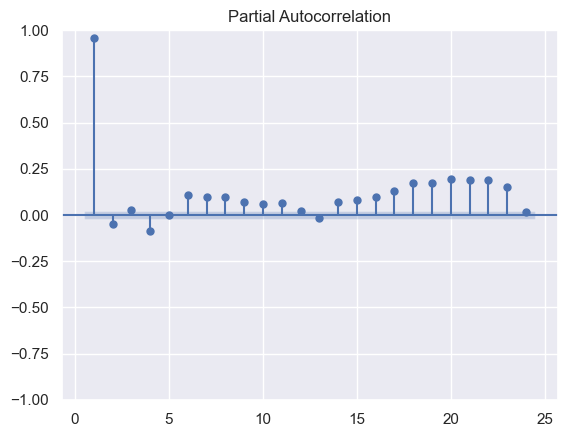

In [152]:
from statsmodels.graphics.tsaplots import plot_pacf

pacf_values = plot_pacf(
    sample_df.loc[sample_df["prediction_unit_id"] == 1, "target"],
    lags=24,
    alpha=0.01,
    method="ywm",
    zero=False,
)

## Values

In [155]:
from statsmodels.tsa.stattools import pacf as pacf

In [ ]:
pacf_values, conf_int = pacf(
    sample_df.loc[sample_df["prediction_unit_id"] == 1, "target"],
    nlags=24 * 7,
    alpha=0.05,
)

In [169]:
pacf_values[0] in conf_int[0]

True

In [ ]:
pacf_values

np.float64(0.9602972084477264)

In [175]:
import numpy as np

sorted_indices = np.argsort(pacf_values)[::-1]
pacf_values[sorted_indices][:10]

array([1.        , 0.96029721, 0.19588608, 0.18972711, 0.18905608,
       0.17541468, 0.17228333, 0.15502939, 0.13197392, 0.10906084])

In [178]:
sorted_indices[:30]

array([  0,   1,  20,  22,  21,  18,  19,  23,  17,   6,   7,  16,   8,
        15,  46,  44,  14,   9,  47,  71,  11,  70,  45,  10, 167,  48,
        94,  95,  68, 166])

In [210]:
[(24 * i) for i in range(1, 8)]

[24, 48, 72, 96, 120, 144, 168]

In [185]:
df.head(10)

,datetime,county,is_business,product_type,target,data_block_id,row_id,prediction_unit_id
0,2021-09-01 00:00:00,0.0,0.0,1.0,96.590,0.0,1.0,0
1,2021-09-01 01:00:00,0.0,0.0,1.0,77.691,0.0,123.0,0
2,2021-09-01 02:00:00,0.0,0.0,1.0,91.594,0.0,245.0,0
3,2021-09-01 03:00:00,0.0,0.0,1.0,87.955,0.0,367.0,0
4,2021-09-01 04:00:00,0.0,0.0,1.0,88.184,0.0,489.0,0
5,2021-09-01 05:00:00,0.0,0.0,1.0,89.781,0.0,611.0,0
6,2021-09-01 06:00:00,0.0,0.0,1.0,96.481,0.0,733.0,0
7,2021-09-01 07:00:00,0.0,0.0,1.0,94.592,0.0,855.0,0
8,2021-09-01 08:00:00,0.0,0.0,1.0,77.308,0.0,977.0,0
9,2021-09-01 09:00:00,0.0,0.0,1.0,54.211,0.0,1099.0,0


In [198]:
df_ = df[df["prediction_unit_id"] == 0].copy()
df_.ffill(inplace=True)
df_ = df_[["prediction_unit_id", "datetime", "target"]]
df_.index = df_["datetime"]
df_.head()

,prediction_unit_id,datetime,target
datetime,,,
2021-09-01 00:00:00,0,2021-09-01 00:00:00,96.590
2021-09-01 01:00:00,0,2021-09-01 01:00:00,77.691
2021-09-01 02:00:00,0,2021-09-01 02:00:00,91.594
2021-09-01 03:00:00,0,2021-09-01 03:00:00,87.955
2021-09-01 04:00:00,0,2021-09-01 04:00:00,88.184


In [ ]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean

fcst = MLForecast(
    models=[],
    freq="H",
    lags=[24, 48],
    # lag_transforms=[24, 48],
    date_features=["month", "dayofweek", "hour"],
)
df_transformed = fcst.preprocess(
    df_,
    id_col="prediction_unit_id",
    time_col="datetime",
    target_col="target",
    # static_features=static_features,
)

In [200]:
df_transformed.head()

,prediction_unit_id,datetime,target,lag24,lag48,month,dayofweek,hour
datetime,,,,,,,,
2021-09-03 00:00:00,0,2021-09-03 00:00:00,107.129,109.366,96.590,9,4,0
2021-09-03 01:00:00,0,2021-09-03 01:00:00,81.920,97.033,77.691,9,4,1
2021-09-03 02:00:00,0,2021-09-03 02:00:00,96.193,104.854,91.594,9,4,2
2021-09-03 03:00:00,0,2021-09-03 03:00:00,94.536,103.433,87.955,9,4,3
2021-09-03 04:00:00,0,2021-09-03 04:00:00,99.585,105.858,88.184,9,4,4


In [208]:
df_.loc["2021-08-31 21:00:00":"2021-09-01 03:00:00"]

,prediction_unit_id,datetime,target
datetime,,,
2021-09-01 00:00:00,0,2021-09-01 00:00:00,96.590
2021-09-01 01:00:00,0,2021-09-01 01:00:00,77.691
2021-09-01 02:00:00,0,2021-09-01 02:00:00,91.594
2021-09-01 03:00:00,0,2021-09-01 03:00:00,87.955


In [193]:
df_.index = df_["datetime"]

In [197]:
df_.index

DatetimeIndex(['2021-09-01 00:00:00', '2021-09-01 01:00:00',
               '2021-09-01 02:00:00', '2021-09-01 03:00:00',
               '2021-09-01 04:00:00', '2021-09-01 05:00:00',
               '2021-09-01 06:00:00', '2021-09-01 07:00:00',
               '2021-09-01 08:00:00', '2021-09-01 09:00:00',
               ...
               '2023-05-31 14:00:00', '2023-05-31 15:00:00',
               '2023-05-31 16:00:00', '2023-05-31 17:00:00',
               '2023-05-31 18:00:00', '2023-05-31 19:00:00',
               '2023-05-31 20:00:00', '2023-05-31 21:00:00',
               '2023-05-31 22:00:00', '2023-05-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=15312, freq=None)